## PD 9 Tomasz Klonecki

In [3]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [4]:
def intersection_distance(data_1, data_2, bins_nr):
    """
    Function to calculate intersection_distance between histogram values
    """
    samples = len(data_1)
    hist_1 = np.histogram(data_1, range=(-1,1), bins=bins_nr)
    hist_2 = np.histogram(data_2, range=(-1,1), bins=bins_nr)
    intersection_distance = []
    
    for i in range(bins_nr):
        intersection_distance.append(min(hist_1[0][i]/samples,hist_2[0][i]/samples))
    np.array(intersection_distance)

    intersection_distance = 1 - sum(intersection_distance)
    return intersection_distance

In [20]:
def pd_plot_intersection(model_1, features_1, model_2, features_2):
    """
    Function to plot PD-plots and calculate area between them for all variables of features
    """
    assert features_1.shape[1] == features_2.shape[1]
    
    colnames = list(features_1.columns)
    features_1 = np.round(features_1.values,2)
    features_2 = np.round(features_2.values,2)
    variable_cnt = features_1.shape[1]
      
    # Draw figure
    fig, axes = plt.subplots(variable_cnt, 1, figsize=(7, 40))
#     plt.subplots_adjust(left=None, bottom=1, right=None, top=1.5, wspace=None, hspace=None)
    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    for feature_index in tqdm(range(variable_cnt), desc = 'Creating PD-plots'):
        # Ceteris Paribus lines for all observations and PD-plot
        unique_features_1 = set(features_1[:,feature_index])
        unique_features_2 = set(features_2[:,feature_index])
        unique_features = np.sort(np.array(list(unique_features_1.intersection(unique_features_2))))
        pd_values_1 = []
        pd_values_2 = []
        if len(unique_features) <= 1:
            axes[feature_index].set_title('Variable ID: '+'%2.0f' % feature_index)
            axes[feature_index].text(0.5, 0.5, 'No common values between datasets\nData differ a lot', 
                    transform=axes[feature_index].transAxes, 
                    fontsize=18,
                    horizontalalignment='center',
                    verticalalignment='center',
                    bbox=props,
                    zorder = 20)
        else:
            for j in range(features_1.shape[0]):
                x_to_predict = np.tile(features_1[j],(len(unique_features),1))
                x_to_predict[:,feature_index] = unique_features
                y = model_1.predict_proba(x_to_predict)[:,1]
                pd_values_1.append(y)

            for j in range(features_2.shape[0]):
                x_to_predict = np.tile(features_2[j],(len(unique_features),1))
                x_to_predict[:,feature_index] = unique_features
                y = model_2.predict_proba(x_to_predict)[:,1]
                pd_values_2.append(y)

            axes[feature_index].plot(unique_features, np.mean(pd_values_1, axis = 0), color = 'black',linewidth = 5 , zorder = 15, label = 'PD plot model 1')
            axes[feature_index].plot(unique_features, np.mean(pd_values_2, axis = 0), color = 'blue',linewidth = 5 , zorder = 15, label = 'PD plot model 2')
            pd_plots_diff = np.mean(abs(np.mean(pd_values_1, axis = 0) - np.mean(pd_values_2, axis = 0)))
            
            axes[feature_index].text(0.03, 0.95, 'Area betweend PD plots : '+'%3.3f' % pd_plots_diff, 
                    transform=axes[feature_index].transAxes, 
                    fontsize=10,
                    verticalalignment='top', 
                    bbox=props,
                    zorder = 20)
            axes[feature_index].set_title('Variable ID: '+'%2.0f' % feature_index)
            axes[feature_index].set_ylabel('Probability')
            axes[feature_index].legend(loc='lower right')
            axes[feature_index].fill_between(unique_features, y1 = np.mean(pd_values_1, axis = 0), y2 = np.mean(pd_values_2, axis = 0))

## Data import and model preparation
Załadowanie danych **HYPERPLANES**

In [6]:
features = pd.read_csv('features.data', header=None, sep=" ")
labels = pd.read_csv('labels.csv', header=None)
features.head(1)

,0,1,2,3,4,5,6,7,8,9
0,0.397174,0.347518,0.294057,0.506484,0.115967,0.770536,0.659893,0.156747,0.378202,0.139763


### Podzielenie danych na początkowe i końcowe 10%

In [8]:
features_1 = features.head(int(features.shape[0]*0.1))
features_2 = features.tail(int(features.shape[0]*0.1))
labels_1 = np.array(labels.head(int(labels.shape[0]*0.1))).flatten()
labels_2= np.array(labels.tail(int(labels.shape[0]*0.1))).flatten()

features_1.shape, features_2.shape, labels_1.shape, labels_2.shape

((20000, 10), (20000, 10), (20000,), (20000,))

### Wytrenowanie dwóch modeli na podzielonych zbiorach danych

In [22]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(features_1, labels_1, test_size=0.1)

model_1 = LogisticRegression(solver='lbfgs')
model_1.fit(X_train_1, y_train_1)
pred_1 = model_1.predict_proba(X_test_1)[:,1]
true_1 = y_test_1

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(features_2, labels_2, test_size=0.1)
model_2 = LogisticRegression(solver='lbfgs')
model_2.fit(X_train_2, y_train_2)
pred_2 = model_1.predict_proba(X_test_2)[:,1]
true_2 = y_test_2

## Features - intersection distance
Odległość pomiędzy rozkładami zmiennych w dwóch podzbiorach danych. 
- $1$ to wartość maksymalna i oznacza największą różnicę
- wartości bliskie $0$ oznaczają że rozkład zmiennych jest niemal identyczny.

Można zauważyć, że różnice pomiędzy zmiennymi są dosyć małe $(<0.05)$. Wniosek jest taki, że jeżeli nie znajdziemy innej anomalii między zbiorami, wykorzystanie do ich modelowania tego samego modelu nie powinno być problemem.

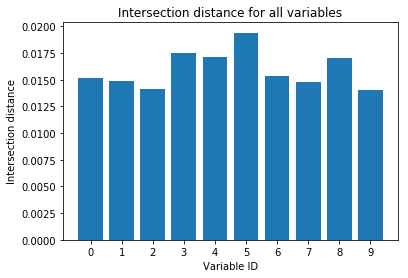

In [23]:
buckets_cnt = 30
intersection_distances = []
for i in range(features.shape[1]):
    data_1 = np.array(features_1.iloc[:,i]).flatten()
    data_2 = np.array(features_2.iloc[:,i]).flatten()
    
    intersection_distances.append(intersection_distance(data_1, data_2, buckets_cnt))

plt.bar(features.columns,intersection_distances)
plt.xticks(features.columns)
plt.title('Intersection distance for all variables')
plt.xlabel('Variable ID')
plt.ylabel('Intersection distance')
plt.show()

## Model residuals - intersection distance

Różnica między rozkładem residuów zwracanych przez model wytrenowany na pierwszych $10\%$ danych. Do wyznaczenia residuów służą natomiast zbiory testowe pochodzące kolejno z pierwszych i ostatnich $10\%$ danych. 

W tym przypadku możemy zauważyć dosyć znaczącą różnicę między resztami. Widać że rozkład residuów z ostatnich $10\%$ ma o wiele cięższe ogony. Oznacza to tyle, że model dopasowany na pierwszych $10\%$ nie jest w stanie dobrze się dostosować dla danych pochodzących z ostatnich $10\%$.

C:\Anaconda\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


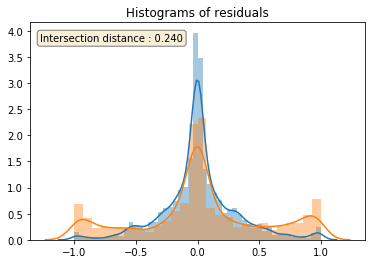

In [24]:
fig, ax = plt.subplots()
data_1 = true_1 - pred_1
data_2 = true_2 - pred_2
sns.distplot(data_1)
sns.distplot(data_2)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.03, 0.95, 'Intersection distance : '+'%3.3f' % intersection_distance(data_1, data_2, 20), 
        transform=ax.transAxes, 
        fontsize=10,
        verticalalignment='top', 
        bbox=props)
plt.title('Histograms of residuals')
plt.show()

## Distance between PD-plots
Obszar pomiędzy krzywymi PD-plot dla modeli wytrenowanych na pierwszych $10\%$ i ostatnich $10\%$ danych.

Większość zmiennych nie wykazuje znaczących różnic pomiędzy krzywymi PD-plot, jednak $4$ z nich wykazują dosyć krytyczne różnice. Zmienne PD-plot mają zupełnie przeciwny kąt nachylenia do osi $x$ i obszary pomiędzy nimi wynoszą więcej niż $0.1$. Jest to sygnał dane z początku i końca zbioru danych dosyć mocno różnią się między sobą. 

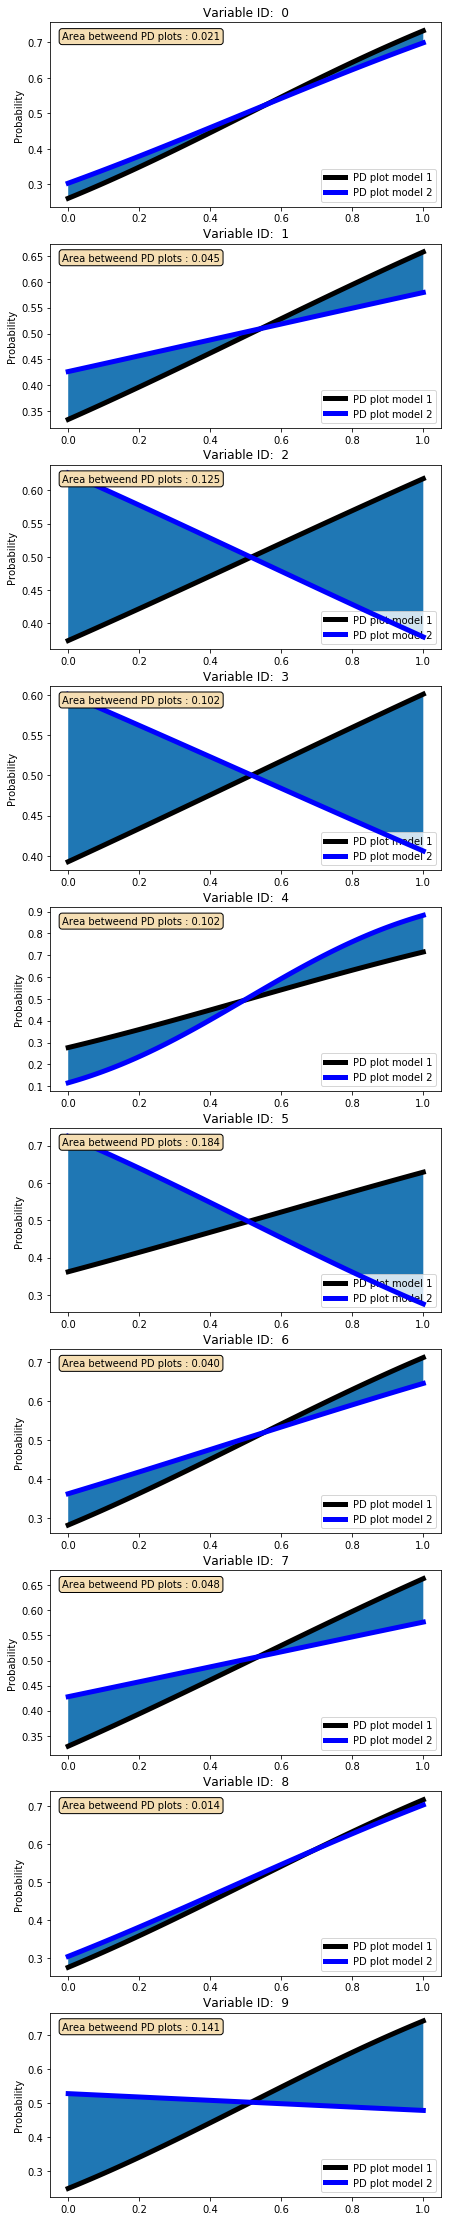

In [25]:
pd_plot_intersection(model_1, features_1, model_2, features_2)

## Wnioski
Z opisu zbioru danych w internecie, wynika że wszystkie zmienne to współrzędne obracającej się hiperpłaszczyzny. Może to tłumaczyć wszystkie różnice, które odkryłem podczas tego zadania. Ogólne rozkłady zmiennych są podobne, bo przedstawiają obroty, współrzędne przechodzą te same punkty w kółko. Natomiast różnice między PD-plotami są znaczące, bo hiperpłaszczyzna w tym momencie dla jednej płaszczyzny pozostaje bez zmian, a dla innej różni się bardzo mocno. 